In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, OPTICS, MeanShift, estimate_bandwidth, AgglomerativeClustering, DBSCAN
from mpl_toolkits.mplot3d import Axes3D
from itertools import cycle
import collections
from sklearn.manifold import MDS
from sklearn.preprocessing import StandardScaler
import re

artists = pd.read_csv('artists.csv')
artworks = pd.read_csv('artworks.csv')
user_events = pd.read_csv('user_events.csv') 
user_favorites = pd.read_csv('user_favorites.csv')
venues = pd.read_csv('venues.csv')

In [4]:
userIDs = user_events['userId'].unique().tolist()
artworkIDs = artworks['artworkId'].unique().tolist()
artistIDs = artworks['artistId'].unique().tolist()
artwork_types = artworks['category'].unique().tolist()

artwork_count = collections.Counter(user_events['artworkId'])
user_count = collections.Counter(user_events['userId'])

artwork_artist_dict = dict()
artwork_type_dict = dict()

for ID in artworkIDs:
    artwork_artist_dict[ID] = np.unique(artworks[artworks['artworkId'] == ID]['artistId'])[0]
    artwork_type_dict[ID] = np.unique(artworks[artworks['artworkId'] == ID]['category'])[0]
    
events = np.array(collections.Counter(user_events['eventName']).most_common(4))[[0,2,3]].tolist()
events = [x[0] for x in events]
    
important_events = user_events[user_events['eventName'].isin(events)]

In [5]:
def artwork_X(artworkIDs,userIDs):
    
    matrix = np.zeros((len(artworkIDs),len(userIDs)))
    X = pd.DataFrame(matrix, columns = userIDs, index = artworkIDs)
    
    for ID1 in userIDs:
        artworks_visited = important_events[important_events['userId'] == ID1]['artworkId'].unique().tolist()
        for ID2 in artworkIDs:
            if ID2 in artworks_visited:
                X.loc[ID2,ID1] = 1
    
    return X

In [6]:
def artist_X(artistIDs,userIDs):
    
    matrix = np.zeros((len(artistIDs),len(userIDs)))
    X = pd.DataFrame(matrix, columns = userIDs, index = artistIDs)
    
    for ID1 in userIDs:
        artworks_visited = important_events[important_events['userId'] == ID1]['artworkId'].unique().tolist()
        artists_visited = []
        for a in artworks_visited:
            if a in artwork_artist_dict.keys():
                artists_visited.append(artwork_artist_dict[a])
        for ID2 in artistIDs:
            if ID2 in artists_visited:
                X.loc[ID2,ID1] = 1
    
    return X

In [7]:
def type_X(artwork_types,userIDs):
    
    matrix = np.zeros((len(artwork_types),len(userIDs)))
    X = pd.DataFrame(matrix, columns = userIDs, index = artwork_types)
    
    for ID1 in userIDs:
        artworks_visited = important_events[important_events['userId'] == ID1]['artworkId'].unique().tolist()
        types = []
        for a in artworks_visited:
            if a in artwork_type_dict.keys():
                types.append(artwork_type_dict[a])
        for ID2 in artwork_types:
            if ID2 in types:
                X.loc[ID2,ID1] = 1
    
    return X

In [8]:
def mds_and_cluster(x,algorithm):
    
    X = StandardScaler().fit_transform(x)
    embed = MDS(n_components=2)
    mds = embed.fit_transform(X)
    
    df = pd.DataFrame(data = mds
                     , columns = ['MDS1', 'MDS2'])
    
    if algorithm == 'K-Means':
        df['group'] = KMeans(n_clusters=4, init='k-means++', random_state=1).fit_predict(x)
    elif algorithm == 'OPTICS':
        df['group'] = OPTICS(min_samples=1).fit_predict(x)
    elif algorithm == 'Mean Shift':
        bandwidth = estimate_bandwidth(df, quantile=0.3)
        df['group'] = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit_predict(x)
    elif algorithm == 'Agglomerative':
        df['group'] = AgglomerativeClustering().fit_predict(x)
    elif algorithm == 'DBSCAN':
        df['group'] = DBSCAN(eps=0.4, min_samples=5).fit_predict(x)
        
    
    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('MDS 1', fontsize = 15)
    ax.set_ylabel('MDS 2', fontsize = 15)
    ax.set_title('2 Component MDS', fontsize = 20)


    targets = np.unique(df['group'])
    colors = cycle('bgrcmy')

    for target, color in zip(targets,colors):
        if target == -1:
            color = 'black'
        indicesToKeep = df['group'] == target
        ax.scatter(df.loc[indicesToKeep, 'MDS1']
                   , df.loc[indicesToKeep, 'MDS2']
                   , c = color
                   , s = 50)
    ax.legend(targets)
    ax.grid()
    
    return df

In [9]:
X = artwork_X(artworkIDs,userIDs)

In [10]:
artistX = artist_X(artistIDs,userIDs)

In [11]:
typeX = type_X(artwork_types,userIDs)

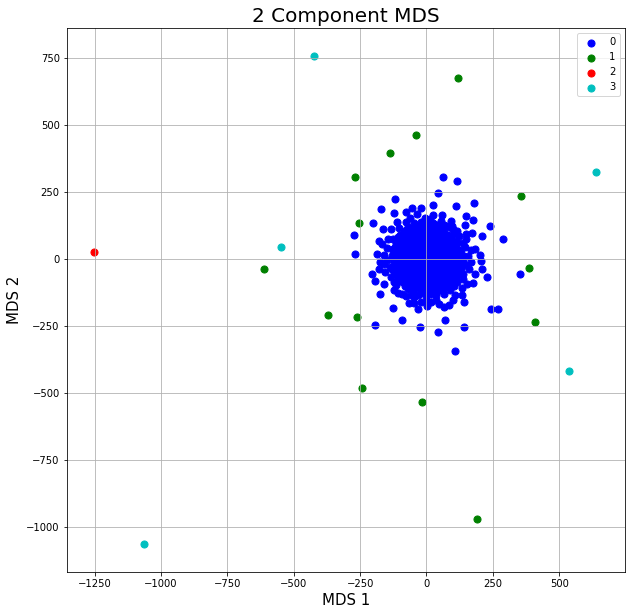

In [13]:
artwork_clusters = mds_and_cluster(X,'K-Means')

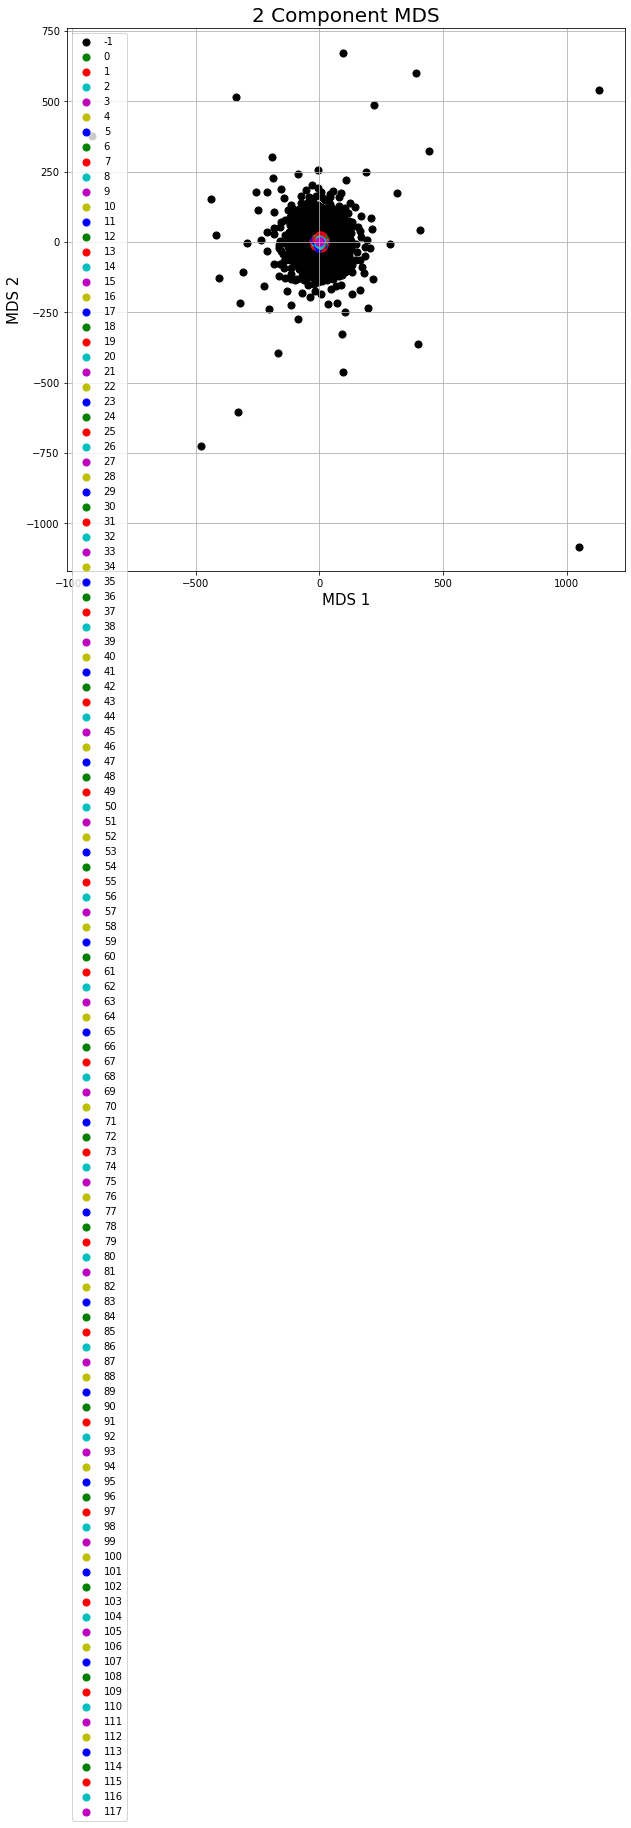

In [15]:
artwork_clusters2 = mds_and_cluster(X,'DBSCAN')

In [ ]:
collections.Counter(artwork_clusters['group'])

In [ ]:
artist_clusters = mds_and_cluster(artistX,'K-Means')

In [ ]:
type_clusters = mds_and_cluster(typeX,'K-Means')

In [ ]:
group_df = artworks[['artworkId','artistId','category']].drop_duplicates()

artist_clusters['ID'] = artistIDs
artist_group = []
for ID in group_df['artistId']:
    artist_group.append(artist_clusters[artist_clusters['ID'] == ID]['group'].tolist()[0])
    
type_clusters['type'] = artwork_types
type_group = []
for c in group_df['category']:
    type_group.append(type_clusters[type_clusters['type'] == c]['group'].tolist()[0])

In [ ]:
group_df['artwork group'] = artwork_clusters['group'].tolist()
group_df['artist group'] = artist_group
group_df['type group'] = type_group

In [ ]:
group_numbers = group_df['artwork group'].unique().tolist()
artwork_list = []
artist_list = []
type_list = []

for num in group_numbers:
    df = group_df[group_df['artwork group'] == num]
    artwork_list.append(df['artworkId'].tolist())
    artist_list.append(df['artistId'].tolist())
    type_list.append(df['category'].tolist())
    
artwork_group_df = pd.DataFrame(group_numbers, columns = ['group number'])

artwork_group_df['artworks'] = artwork_list
artwork_group_df['artists'] = artist_list
artwork_group_df['types'] = type_list

In [ ]:
g0_artworks = dict()
g0_artists = dict()

for aw in artwork_group_df['artists'][1]:
    desc = artists[artists['artistId'] == aw]['description']
    desc.index = range(0,len(desc))
    desc = desc[0]
    if type(desc) == str:
        desc = desc.split()
    else:
        desc = ''
    words = []
    for word in desc:
        words.append(re.sub('[\W_]+', '', word))
    for word in words:
        if word in g0_artists.keys():
            g0_artists[word] += 1
        else:
            g0_artists[word] = 1
            
for aw in artwork_group_df['artworks'][1]:
    desc = artworks[artworks['artworkId'] == aw]['description']
    desc.index = range(0,len(desc))
    desc = desc[0]
    if type(desc) == str:
        desc = desc.split()
    else:
        desc = ''
    words = []
    for word in desc:
        words.append(re.sub('[\W_]+', '', word))
    for word in words:
        if word in g0_artworks.keys():
            g0_artworks[word] += 1
        else:
            g0_artworks[word] = 1

In [ ]:
g0_artists = {k: v for k, v in sorted(g0_artists.items(), reverse = True, key=lambda item: item[1])}
g0_artworks = {k: v for k, v in sorted(g0_artworks.items(), reverse = True, key=lambda item: item[1])}

In [ ]:
g0_artists